<a href="https://colab.research.google.com/github/FaatimahM/Tweet_classification_simpletransformers/blob/main/Tweet_classification_with_simpletransformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AMLD Africa Machine Learning Hackathon

The code for using Simple Transformers to train a Roberta model for text classification can be found in this notebook, following the basic intructions from https://simpletransformers.ai/docs/classification-models/.

The data and further details for this hackathon can be found on Zindi https://zindi.africa/hackathons/amld. This challenge aims to use machine learning to classify tweets about Gender-based violence (GBV). There are 5 categories of tweets, namely Sexual violence, Emotional violence, Economic violence, Physical violence and Harmful traditional practice. 

Environment : Google colab with GPU enabled


### Install modules/packages

In [1]:
!pip install simpletransformers

     |████████████████████████████████| 221 kB 5.0 MB/s 
     |████████████████████████████████| 43 kB 2.2 MB/s 
     |████████████████████████████████| 124 kB 48.2 MB/s 
     |████████████████████████████████| 1.7 MB 35.2 MB/s 
     |████████████████████████████████| 2.8 MB 28.5 MB/s 
     |████████████████████████████████| 3.3 MB 32.8 MB/s 
     |████████████████████████████████| 1.2 MB 49.1 MB/s 
     |████████████████████████████████| 8.0 MB 14.5 MB/s 
     |████████████████████████████████| 264 kB 43.5 MB/s 
     |████████████████████████████████| 895 kB 41.5 MB/s 
     |████████████████████████████████| 636 kB 37.3 MB/s 
     |████████████████████████████████| 50 kB 6.4 MB/s 
     |████████████████████████████████| 97 kB 6.9 MB/s 
     |████████████████████████████████| 170 kB 46.3 MB/s 
     |████████████████████████████████| 133 kB 49.3 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 119 kB 43.4 MB/s 
     |█████████████████

In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import libraries/modules

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample, shuffle
from sklearn.model_selection import train_test_split
from simpletransformers.classification.classification_model import ClassificationModel
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score

### Load the dataset

In [51]:
train = pd.read_csv('/content/drive/MyDrive/gbv/Train.csv')
test = pd.read_csv('/content/drive/MyDrive/gbv/Test.csv')

### EDA
(*I decided to display minimal tweets in this notebook due to their disturbing nature*)

In [6]:
train.shape # the training dataset has 39650 rows

(39650, 3)

In [52]:
train.head(1)

,Tweet_ID,tweet,type
0,ID_0022DWKP,Had a dream i got raped last night. By a guy i...,sexual_violence


In [8]:
# column names
train.columns

Index(['Tweet_ID', 'tweet', 'type'], dtype='object')

In [9]:
# number of classes in this dataset
train['type'].unique()

array(['sexual_violence', 'Physical_violence', 'emotional_violence',
       'Harmful_Traditional_practice', 'economic_violence'], dtype=object)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Frequency of classes')

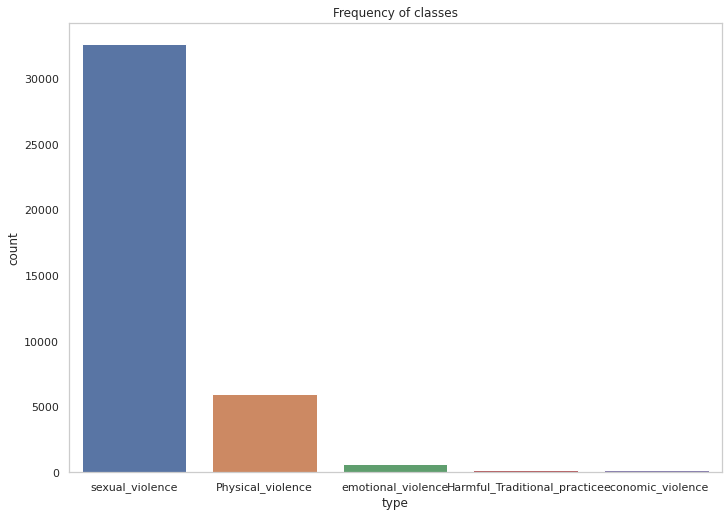

In [13]:
# plot the frequency of the classes
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("whitegrid", {'axes.grid' : False})
sns.countplot(train['type']).set_title('Frequency of classes')

From the graphs above we can see that this dataset is highly imbalanced with sexual violence accounting for about 80%+ of the tweets.  

In [14]:
# check for null values
train.isnull().sum()

Tweet_ID    0
tweet       0
type        0
dtype: int64

In [17]:
test.shape # the test dataset has 15581 rows

(15581, 2)

### Data preparation

In [56]:
# convert categories for text to number using LabelEncoder
le = LabelEncoder()
le.fit(train['type'])
y_train_enc = le.transform(train['type'])
train['type'] = y_train_enc

# remove 'Tweet_ID' column 
train.drop('Tweet_ID', inplace= True, axis = 1)

In [23]:
train['type'].value_counts()

4    32648
1     5946
3      651
2      217
0      188
Name: type, dtype: int64

In [27]:
# manual resampling in an attempt to balance the data from each class
zero = train[train['type'] == 0]
one = train[train['type'] == 1]
two = train[train['type'] == 2]
three = train[train['type'] == 3]
four = train[train['type'] == 4]

samples = 600 #this was an arbitrary selection
rs = 42

zero_resample = resample(zero, replace=True, n_samples=samples, random_state=rs)
one_resample = resample(one, replace=True, n_samples=samples, random_state=rs)
two_resample = resample(two, replace=True, n_samples=samples, random_state=rs)
three_resample = resample(three, replace=True, n_samples=samples, random_state=rs)
four_resample = resample(four, replace=True, n_samples=samples, random_state=rs)

# join the data to form a new training set
resample_train = pd.concat([zero_resample,one_resample,two_resample,three_resample,four_resample])

In [28]:
# check the frequency of data in each class in the new training set
resample_train['type'].value_counts()

3    600
1    600
4    600
2    600
0    600
Name: type, dtype: int64

In [29]:
# split the data into training and validation sets
trn, val = train_test_split(resample_train, test_size=0.15, random_state=2)

### Train Model

In [30]:
%%time 
# create a TransformerModel
model = ClassificationModel('roberta', 'roberta-base', num_labels=5,args={'num_train_epochs': 1,
                                                                         'manual_seed': 2,
                                                                         'learning_rate': 2e-5,
                                                                         'overwrite_output_dir': True} )

# train the model
model.train_model(trn)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.de

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:616: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2550 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/319 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:942: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  model.parameters(), args.max_grad_norm


CPU times: user 3min 14s, sys: 1min 21s, total: 4min 36s
Wall time: 5min


### Evaluate model

In [42]:
## use the model on the evaluation dataset
# val_predicted = model.predict(list(val['tweet']))
# np.unique(val_predicted)
# accuracy_score(val['type'],val_predicted[0])

0.9933333333333333

### Make a submission into the competition

In [53]:
# # use the model to make predictions on the test dataset
# predictions, raw_outputs = model.predict(list(test['tweet']))

# # use the LabelEncoder to change the classes from numbers back to text
# preds =  le.inverse_transform(predictions)

submission = pd.read_csv('/content/drive/MyDrive/gbv/SampleSubmission.csv')
submission['type'] = preds
submission.to_csv('roberta_model.csv', index=False)

In [54]:
submission.head(1)

,Tweet_ID,type
0,ID_0095QL4S,emotional_violence


Note: this model produced an accuracy of 0.762 on the leaderboard.

### **Update**
For data that isn't balanced, a weight paramter can be set to balance the classes. The code below details the attempt at setting these weights with using the entire dataset. I'm not sure if I did this correctly, but it improved the accuracy on the leaderboard to 0.775. 

In [ ]:
%%time 
# create a TransformerModel
model2 = ClassificationModel('roberta', 'roberta-base', num_labels=5, weight = [0.51,0.01,0.46,0.15,0.003],args={
                                                                         'num_train_epochs': 1,
                                                                         'manual_seed': 2,
                                                                         "learning_rate": 2e-5,
                                                                         'overwrite_output_dir': True} )

# train the model
model2.train_model(train)